## CrowdED: Crowdsourcing task optimization
The research question we aim to answer is: "Can we a-priori estimate optimal workers and tasks' assignment to obtain maximum accuracy on all tasks?"

In [1]:
import sys
import pandas as pd
import numpy as np
import shortuuid as uid
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

---
### Stage 0: Tasks and Workers Dataframe Construction

The requester has the option to configure the following variables:
- Number of workers
- Number of tasks
- Number of tasks per worker
- % Hard/Easy tasks
- % Poor/Good workers

In [2]:
total_tasks = 100

In [3]:
total_workers = 40

In [4]:
#Tasks variables
p_hard_tasks = 0.1
n_hard_tasks = int(round(p_hard_tasks*total_tasks,0))

p_easy_tasks = 1-p_hard_tasks 
n_easy_tasks = int(round(p_easy_tasks*total_tasks,0))

In [5]:
print(n_hard_tasks, n_easy_tasks)

10 90


In [6]:
#Workers variables
p_good_workers = 0.9
n_good_workers = int(round(p_good_workers*total_workers,0))

p_poor_workers = 1-p_good_workers
n_poor_workers = int(round(p_poor_workers*total_workers,0))

In [7]:
print(n_good_workers, n_poor_workers)

36 4


Next, we randomly assign (without [replacement](https://www.ma.utexas.edu/users/parker/sampling/repl.htm)) the tasks to the workers depending on the variable values specified.

- Workers

In [8]:
workers = [uid.ShortUUID().random(length=5) for i in range(total_workers)]

In [9]:
poor_workers = [worker for worker in np.random.choice(workers, n_poor_workers, replace=False)]

In [10]:
good_workers = [worker for worker in set(workers)-set(poor_workers)]

Every worker has X number of tasks to accomplish. So next, we select each task randomly (with replacement) and assign them to each worker.

In [11]:
# Creating the workers dataframe
df_workers = pd.DataFrame()
df_workers['worker_id'] = workers

In [12]:
label_worker = ['good_worker' if workers[i] in good_workers else 'poor_worker' for i in range(total_workers)]

In [13]:
df_workers['label_worker'] = label_worker

In [14]:
df_workers.head()

worker_id label_worker
0     3smCh  good_worker
1     QNMtU  good_worker
2     zY8M8  good_worker
3     nvJiD  good_worker
4     DY9Uz  good_worker

- Tasks 

In [15]:
tasks = ['task_'+uid.ShortUUID().random(length=3) for i in range(total_tasks)]

In [16]:
easy_tasks = [task for task in np.random.choice(tasks, n_easy_tasks, replace=False)]

In [17]:
hard_tasks = [task for task in set(tasks)-set(easy_tasks)]

- True Answers

In our simulation, the task is that the worker has to choose one out of the five given answers.

In [18]:
answers_key = ["liver", "blood", "lung", "brain", "heart"]

In [19]:
true_answers = [answer for answer in np.random.choice(answers_key, total_tasks)]

Here, we simulate the true answer for each worker-task pair.

In [20]:
# Creating the tasks data frame
df_tasks = pd.DataFrame()
df_tasks['task_id'] = tasks
df_tasks['true_answers'] = true_answers

In [21]:
label_task = ['hard_task' if tasks[i] in hard_tasks else 'easy_task' for i in range(total_tasks)]

In [22]:
df_tasks['label_task'] = label_task

In [23]:
df_tasks.head()

task_id real_answers label_task
0  task_pUN        brain  easy_task
1  task_hoz        brain  easy_task
2  task_SKz        heart  easy_task
3  task_2rv        brain  easy_task
4  task_fcd        liver  easy_task

---
### Probabilities of getting the answer right
In this step, we simulate the workers answer based on the pre-assumed probabilities.

$p_T =$ task difficulty  
$p_W =$ worker ability

$$p_T \in (0.5,1)$$
$$p_W \in (0.5,1)$$

In [24]:
# Threshold of responses
cut_tasks = 0.75
cut_workers = 0.75

In [25]:
probs_tasks = []
for i in label_task:
    if i == 'easy_task':
        probs_tasks.append(np.random.choice((np.arange(cut_tasks, 1, 0.01)), 1)) #a random number form cut to 1
    elif i == 'hard_task':
        probs_tasks.append(np.random.choice((np.arange(0.5, cut_tasks, 0.01)), 1)) #a random number form chance to cut
    else: probs_tasks.append(1)

probs_tasks = [item for prob in probs_tasks for item in prob]

In [26]:
probs_workers = []
for i in label_worker:
    if i == 'good_worker':
        probs_workers.append(np.random.choice((np.arange(cut_workers, 1, 0.01)), 1)) #a random number form cut to 1
    elif i == 'poor_worker':
        probs_workers.append(np.random.choice((np.arange(0.5, cut_workers, 0.01)), 1)) #a random number form chance to 1
    else: probs_workers.append(1)

probs_workers = [item for prob in probs_workers for item in prob]

In [27]:
df_workers['prob_worker'] = probs_workers

In [28]:
df_workers.head()

worker_id label_worker  prob_worker
0     3smCh  good_worker         0.89
1     QNMtU  good_worker         0.92
2     zY8M8  good_worker         0.92
3     nvJiD  good_worker         0.91
4     DY9Uz  good_worker         0.93

In [29]:
df_tasks['prob_task'] = probs_tasks

In [30]:
df_tasks.head()

task_id real_answers label_task  prob_task
0  task_pUN        brain  easy_task       0.89
1  task_hoz        brain  easy_task       0.87
2  task_SKz        heart  easy_task       0.75
3  task_2rv        brain  easy_task       0.92
4  task_fcd        liver  easy_task       0.77

#### Summary of aggregated probabilities

In [31]:
df_tasks.groupby('label_task').agg(['mean','count'])

prob_task      
                mean count
label_task                
easy_task   0.876556    90
hard_task   0.620000    10

In [32]:
df_workers.groupby('label_worker').agg(['mean','count'])

prob_worker      
                    mean count
label_worker                  
good_worker       0.8750    36
poor_worker       0.6275     4

---
### Stage 1 - Training Workers
- Select the p% of the tasks
- Assign 'workers_per_task' (7 this case) to every p% of the task of the training set
- Simulate truth and worker answers

In [33]:
p_train_tasks = .4 #percentage

In [34]:
workers_per_task = 7

In [35]:
tasks_to_train = int(p_train_tasks*total_tasks)
tasks_to_train

40

In [36]:
# From the entire set of tasks, randomly choose p_train_tasks (in this case 40) tasks to train.
training_tasks = np.random.choice(tasks, tasks_to_train, replace=False)
training_tasks

array(['task_HpK', 'task_XBn', 'task_7ER', 'task_hoz', 'task_qAk',
       'task_poe', 'task_yAd', 'task_YGt', 'task_HQM', 'task_z3K',
       'task_vBh', 'task_A9N', 'task_tfp', 'task_nEC', 'task_pUN',
       'task_miS', 'task_kt2', 'task_uiT', 'task_DYZ', 'task_wGS',
       'task_yqR', 'task_9Kn', 'task_KwC', 'task_9vN', 'task_mEh',
       'task_nw6', 'task_5pJ', 'task_SKz', 'task_mgZ', 'task_ymJ',
       'task_MA3', 'task_kaD', 'task_m3n', 'task_57T', 'task_wQ6',
       'task_ipS', 'task_abo', 'task_KUp', 'task_L4d', 'task_B4D'],
      dtype='<U8')

In [37]:
list_tasks1 = [[training_tasks[i]]*workers_per_task for i in range(tasks_to_train)] #replicate the tasks to train 
list_tasks1 = [item for sublist in list_tasks1 for item in sublist] #flat and clean list

In [38]:
# Asign workers on every task (we're assuming the tasks are ordered)
tasks_workers1 = [np.random.choice(workers, workers_per_task, replace=False) for task in training_tasks]
tasks_workers1 = [worker for sublist in tasks_workers1 for worker in sublist] #flat and clean list

In [39]:
df_tw1 = pd.DataFrame()
df_tw1['task_id'] = list_tasks1
df_tw1['worker_id'] = tasks_workers1

In [40]:
workers_agg = df_tw1.groupby('worker_id').agg('count')

In [41]:
workers_agg.sort_values('task_id', ascending=False)

task_id
worker_id         
oy3Gb           12
6dV3n           11
YDBnr           11
KdXE5           11
qsGJR           10
9mik3           10
3smCh           10
PkWqW           10
ymWFy            8
MLk54            8
gi5bi            8
Yw43m            8
QNMtU            8
PrHGf            8
kGSko            8
KLBmh            8
CFh3k            8
ytjfP            7
FanXm            7
DY9Uz            7
ChsV7            7
hFWtm            7
hSaX2            7
UvyT8            7
BB8sK            6
7qyBj            6
iGmZs            6
73phF            6
sqsGB            5
rj4WG            5
3Ua4g            5
RrJJ7            5
M3Ztt            5
zY8M8            5
mJBPn            4
X85zU            4
nvJiD            3
ix48q            3
sGWZx            3
MNF9G            3

In [42]:
len(workers_agg.reset_index())

40

Then, we merge the tasks and workers datasets along with the probabilities of getting the answer right.

In [43]:
df_tw1 = pd.merge(df_tw1, df_tasks, on='task_id', how='left')
df_tw1 = pd.merge(df_tw1, df_workers, on='worker_id', how='left')

In [44]:
#Probability to getting the answer right
df_tw1['prob_answer'] = 1-(df_tw1['prob_worker']*(1-df_tw1['prob_task']))

In [45]:
df_tw1['prob_answer'].head(10)

0    0.9925
1    0.9942
2    0.9922
3    0.9908
4    0.9905
5    0.9924
6    0.9917
7    0.9288
8    0.9264
9    0.9248
Name: prob_answer, dtype: float64

In [46]:
positions = []
for answer in df_tw1['true_answers']:
    for k in range(len(answers_key)):
        if answers_key[k] == answer:
            positions.append(k)

In [47]:
# Assign a vector of probabilities depending on the position of the item on answer_key array
list_vect_probs = []
for p in df_tw1['prob_answer']:
    for i in positions:
        vec_probs = [(1-p)/(len(answers_key)-1)] * (len(answers_key)-1)
        vec_probs.insert(i,p) #insert place, value
    list_vect_probs.append(vec_probs)

#### Worker answer prediction

In [48]:
#"Predict" every answer
worker_answers = []
for vec in list_vect_probs:
    worker_answers.append(np.random.choice(answers_key, 1, p=vec))

worker_answers = [item for answer in worker_answers for item in answer]

In [49]:
df_tw1['worker_answers'] = worker_answers

In [50]:
#We match the true answers with the worker answers
vec_matches = df_tw1['worker_answers'] == df_tw1['true_answers']
predict_value =[1 if i == True else 0 for i in vec_matches]

In [51]:
df_tw1['performance'] = predict_value

In [52]:
df_tw1.head()

task_id worker_id real_answers label_task  prob_task label_worker  \
0  task_HpK     qsGJR        blood  easy_task       0.99  good_worker   
1  task_HpK     BB8sK        blood  easy_task       0.99  poor_worker   
2  task_HpK     FanXm        blood  easy_task       0.99  good_worker   
3  task_HpK     QNMtU        blood  easy_task       0.99  good_worker   
4  task_HpK     sGWZx        blood  easy_task       0.99  good_worker   

   prob_worker  prob_answer worker_answers  performance  
0         0.75       0.9925          heart            0  
1         0.58       0.9942          heart            0  
2         0.78       0.9922          heart            0  
3         0.92       0.9908          heart            0  
4         0.95       0.9905          heart            0

---
### Measuring Performance

Now we aggregate the tasks by the mean. The average of the predicted value is the same as calculate the number of times a worker answer right over the number of workers per task.  

The range of the predict value goes from 0 to 1, so it means that the more closest to 1 the workers get more consensus, in the other hand if is closest to 0 then means that there was no consensus.

- Trained Tasks

In [53]:
tasks_mean1 = df_tw1.groupby('task_id').mean().sort_values('performance', ascending=False)
tasks_mean1['performance']#.head(10)

task_id
task_MA3    1.000000
task_nEC    1.000000
task_5pJ    1.000000
task_HQM    1.000000
task_57T    0.857143
task_mEh    0.857143
task_ipS    0.857143
task_B4D    0.857143
task_poe    0.714286
task_qAk    0.714286
task_SKz    0.571429
task_mgZ    0.142857
task_KwC    0.142857
task_ymJ    0.142857
task_9Kn    0.142857
task_miS    0.000000
task_vBh    0.000000
task_tfp    0.000000
task_wGS    0.000000
task_wQ6    0.000000
task_pUN    0.000000
task_yAd    0.000000
task_nw6    0.000000
task_yqR    0.000000
task_uiT    0.000000
task_kaD    0.000000
task_m3n    0.000000
task_kt2    0.000000
task_hoz    0.000000
task_abo    0.000000
task_YGt    0.000000
task_XBn    0.000000
task_L4d    0.000000
task_KUp    0.000000
task_HpK    0.000000
task_DYZ    0.000000
task_A9N    0.000000
task_9vN    0.000000
task_7ER    0.000000
task_z3K    0.000000
Name: performance, dtype: float64

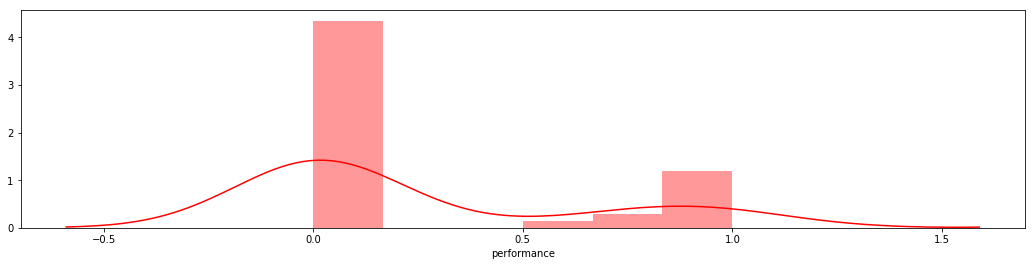

In [54]:
#Distribution
plt.figure(figsize=[18, 4])
sns.distplot(tasks_mean1['performance'], bins=6, color='red')

In [55]:
cutoff_task = 0.5 #More than 50% of consensus
print('All the hard tasks that go to Stage 2 are below {}'.format(cutoff_task))

All the hard tasks that go to Stage 2 are below 0.5


In [56]:
tasks_mean1[tasks_mean1['performance'] >= cutoff_task]

prob_task  prob_worker  prob_answer  performance
task_id                                                   
task_MA3       0.85     0.810000     0.878500     1.000000
task_nEC       0.96     0.812857     0.967486     1.000000
task_5pJ       0.79     0.874286     0.816400     1.000000
task_HQM       0.99     0.830000     0.991700     1.000000
task_57T       0.88     0.871429     0.895429     0.857143
task_mEh       0.86     0.770000     0.892200     0.857143
task_ipS       0.75     0.867143     0.783214     0.857143
task_B4D       0.88     0.821429     0.901429     0.857143
task_poe       0.78     0.860000     0.810800     0.714286
task_qAk       0.86     0.808571     0.886800     0.714286
task_SKz       0.75     0.812857     0.796786     0.571429

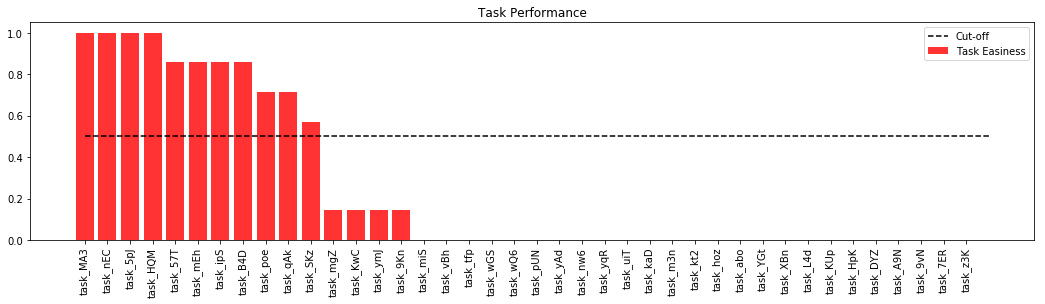

In [57]:
plt.figure(figsize=[18, 4])
axis = range(len(tasks_mean1))
plt.bar(axis, tasks_mean1['performance'], align='center', alpha=0.8, color='red', label='Task Easiness')
plt.hlines(y=cutoff_task, xmin=0, xmax=len(tasks_mean1), linestyles='--', label='Cut-off')
plt.xticks(axis, tasks_mean1.index, rotation=90)
plt.title('Task Performance')
plt.legend(loc='best')
plt.show()

- Trained Workers

In [58]:
workers_mean1 = df_tw1.groupby('worker_id').mean().sort_values('performance', ascending=False)
df_workers = pd.merge(workers_mean1.reset_index(), df_workers.drop('prob_worker',1), on='worker_id', how='left')

- prob_task: Average of difficulty of the tasks asigned to the workers, this measure should be close each other in order to make the metrics equivalent
- prob_worker: Probability of getting the answer right
- prob_answer: Combined probability of score and task difficulty
- performance: Percentage of the times the worker answered correctly

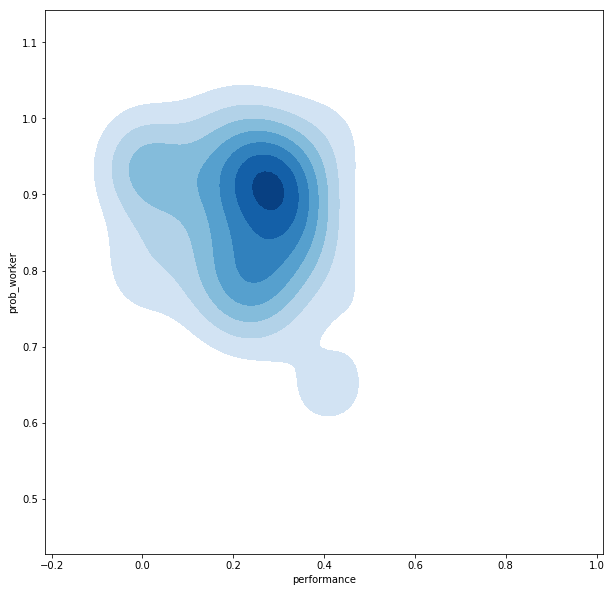

In [59]:
plt.figure(figsize=[10, 10])
sns.kdeplot(df_workers['performance'], df_workers['prob_worker'], cmap="Blues", shade=True, shade_lowest=False)

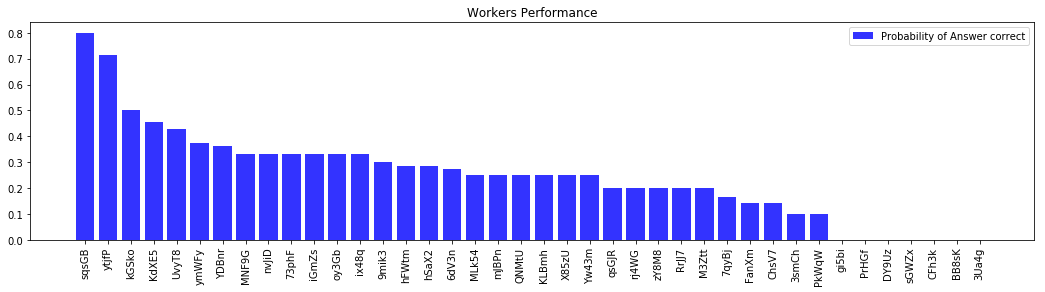

In [60]:
plt.figure(figsize=[18, 4])
axis = range(len(workers_mean1))
plt.bar(axis, workers_mean1['performance'], align='center', alpha=0.8, color='blue', label='Probability of Answer correct')
plt.xticks(axis, workers_mean1.index, rotation=90)
plt.title('Workers Performance')
plt.legend(loc='best')
plt.show()

Maybe we don't want to let go the workers with high probability just because they had bad performance

In [61]:
df_workers.describe()

prob_task  prob_worker  prob_answer  performance
count  40.000000     40.00000    40.000000    40.000000
mean    0.873096      0.85025     0.891854     0.248314
std     0.042474      0.10164     0.039390     0.179376
min     0.746667      0.58000     0.774533     0.000000
25%     0.850938      0.78750     0.870850     0.142857
50%     0.876607      0.88000     0.898234     0.250000
75%     0.896786      0.92250     0.919403     0.333333
max     0.960000      0.99000     0.969600     0.800000

In [62]:
cutoff_prob = df_workers['prob_worker'].quantile(.5)
cutoff_perf = df_workers['performance'].quantile(.5)
print('Cutoff: \n Performance: {} \n Probability: {}'.format(
    round(cutoff_perf, 3), round(cutoff_prob, 3)))

Cutoff: 
 Performance: 0.25 
 Probability: 0.88


In [63]:
df_workers #All workers

worker_id  prob_task  prob_worker  prob_answer  performance label_worker
0      sqsGB   0.870000         0.65     0.915500     0.800000  poor_worker
1      ytjfP   0.837143         0.87     0.858314     0.714286  good_worker
2      kGSko   0.877500         0.75     0.908125     0.500000  good_worker
3      KdXE5   0.879091         0.64     0.922618     0.454545  poor_worker
4      UvyT8   0.862857         0.98     0.865600     0.428571  good_worker
5      ymWFy   0.872500         0.83     0.894175     0.375000  good_worker
6      YDBnr   0.895455         0.64     0.933091     0.363636  poor_worker
7      MNF9G   0.863333         0.90     0.877000     0.333333  good_worker
8      nvJiD   0.836667         0.91     0.851367     0.333333  good_worker
9      73phF   0.905000         0.83     0.921150     0.333333  good_worker
10     iGmZs   0.781667         0.86     0.812233     0.333333  good_worker
11     oy3Gb   0.867500         0.94     0.875450     0.333333  good_worker
12     ix48q   0.746667         0.89     0.774533     0.333333  good_worker
13     9mik3   0.904000         0.81     0.922240     0.300000  good_worker
14     hFWtm   0.878571         0.97     0.882214     0.285714  good_worker
15     hSaX2   0.850000         0.77     0.884500     0.285714  good_worker
16     6dV3n   0.860909         0.91     0.873427     0.272727  good_worker
17     MLk54   0.868750         0.78     0.897625     0.250000  good_worker
18     mJBPn   0.960000         0.76     0.969600     0.250000  good_worker
19     QNMtU   0.851250         0.92     0.863150     0.250000  good_worker
20     KLBmh   0.908750         0.92     0.916050     0.250000  good_worker
21     X85zU   0.840000         0.94     0.849600     0.250000  good_worker
22     Yw43m   0.932500         0.90     0.939250     0.250000  good_worker
23     qsGJR   0.887000         0.75     0.915250     0.200000  good_worker
24     rj4WG   0.908000         0.84     0.922720     0.200000  good_worker
25     zY8M8   0.900000         0.92     0.908000     0.200000  good_worker
26     RrJJ7   0.918000         0.99     0.918820     0.200000  good_worker
27     M3Ztt   0.776000         0.80     0.820800     0.200000  good_worker
28     7qyBj   0.848333         0.84     0.872600     0.166667  good_worker
29     FanXm   0.875714         0.78     0.903057     0.142857  good_worker
30     ChsV7   0.895714         0.97     0.898843     0.142857  good_worker
31     3smCh   0.888000         0.89     0.900320     0.100000  good_worker
32     PkWqW   0.850000         0.92     0.862000     0.100000  good_worker
33     gi5bi   0.833750         0.94     0.843725     0.000000  good_worker
34     PrHGf   0.888750         0.79     0.912113     0.000000  good_worker
35     DY9Uz   0.867143         0.93     0.876443     0.000000  good_worker
36     sGWZx   0.950000         0.95     0.952500     0.000000  good_worker
37     CFh3k   0.885000         0.93     0.893050     0.000000  good_worker
38     BB8sK   0.878333         0.58     0.929433     0.000000  poor_worker
39     3Ua4g   0.924000         0.82     0.937680     0.000000  good_worker

---
### Stage 2
We are going take only the best workers, it means high probability and high performance, above certain percentile. 

In [64]:
list_perf = [1 if i > cutoff_perf else 0 for i in df_workers['performance']]
#list_perf

In [65]:
list_prob = [1 if i > cutoff_prob else 0 for i in df_workers['prob_worker']]
#list_prob

In [66]:
flag_best_workers = []
for i in range(len(list_perf)):
    if list_perf[i] == 1 and list_prob[i] ==1 : #we need to be strict here
        flag_best_workers.append(1)
    else: flag_best_workers.append(0)

In [67]:
print('Selected Best Workers: {}'.format(sum(flag_best_workers)))

Selected Best Workers: 7


In [68]:
df_workers['best_worker'] = flag_best_workers

In [69]:
df_workers2 = df_workers[df_workers['best_worker']==1]

But we want to "reset" them:

In [70]:
df_workers2 = df_workers2[['worker_id','prob_worker','label_worker']]
df_workers2

worker_id  prob_worker label_worker
4      UvyT8         0.98  good_worker
7      MNF9G         0.90  good_worker
8      nvJiD         0.91  good_worker
11     oy3Gb         0.94  good_worker
12     ix48q         0.89  good_worker
14     hFWtm         0.97  good_worker
16     6dV3n         0.91  good_worker

In [71]:
best_workers = [i for i in df_workers2['worker_id']]

In [72]:
best_workers

['UvyT8', 'MNF9G', 'nvJiD', 'oy3Gb', 'ix48q', 'hFWtm', '6dV3n']

- Now we take the tasks that we decide were already difficult
- Then we're going to add them in the df_tasks that we did not use
- This "rest" of the tasks remain are going to be performed for our final workers

In [73]:
tasks_mean1 = tasks_mean1.reset_index()

In [74]:
tasks_mean1

task_id  prob_task  prob_worker  prob_answer  performance
0   task_MA3       0.85     0.810000     0.878500     1.000000
1   task_nEC       0.96     0.812857     0.967486     1.000000
2   task_5pJ       0.79     0.874286     0.816400     1.000000
3   task_HQM       0.99     0.830000     0.991700     1.000000
4   task_57T       0.88     0.871429     0.895429     0.857143
5   task_mEh       0.86     0.770000     0.892200     0.857143
6   task_ipS       0.75     0.867143     0.783214     0.857143
7   task_B4D       0.88     0.821429     0.901429     0.857143
8   task_poe       0.78     0.860000     0.810800     0.714286
9   task_qAk       0.86     0.808571     0.886800     0.714286
10  task_SKz       0.75     0.812857     0.796786     0.571429
11  task_mgZ       0.75     0.817143     0.795714     0.142857
12  task_KwC       0.76     0.814286     0.804571     0.142857
13  task_ymJ       0.80     0.885714     0.822857     0.142857
14  task_9Kn       0.56     0.877143     0.614057     0.142857
15  task_miS       0.93     0.895714     0.937300     0.000000
16  task_vBh       0.77     0.874286     0.798914     0.000000
17  task_tfp       0.99     0.875714     0.991243     0.000000
18  task_wGS       0.83     0.900000     0.847000     0.000000
19  task_wQ6       0.98     0.867143     0.982657     0.000000
20  task_pUN       0.89     0.865714     0.904771     0.000000
21  task_yAd       0.97     0.757143     0.977286     0.000000
22  task_nw6       0.93     0.810000     0.943300     0.000000
23  task_yqR       0.98     0.882857     0.982343     0.000000
24  task_uiT       0.96     0.858571     0.965657     0.000000
25  task_kaD       0.91     0.851429     0.923371     0.000000
26  task_m3n       0.96     0.861429     0.965543     0.000000
27  task_kt2       0.93     0.857143     0.940000     0.000000
28  task_hoz       0.87     0.854286     0.888943     0.000000
29  task_abo       0.86     0.880000     0.876800     0.000000
30  task_YGt       0.81     0.891429     0.830629     0.000000
31  task_XBn       0.92     0.885714     0.929143     0.000000
32  task_L4d       0.95     0.791429     0.960429     0.000000
33  task_KUp       0.98     0.848571     0.983029     0.000000
34  task_HpK       0.99     0.795714     0.992043     0.000000
35  task_DYZ       0.84     0.887143     0.858057     0.000000
36  task_A9N       0.75     0.785714     0.803571     0.000000
37  task_9vN       0.99     0.840000     0.991600     0.000000
38  task_7ER       0.91     0.877143     0.921057     0.000000
39  task_z3K       0.86     0.765714     0.892800     0.000000

In [75]:
list_done_tasks = [1 if i > cutoff_task else 0 for i in tasks_mean1['performance']]

In [76]:
tasks_mean1['done_task'] = list_done_tasks

In [77]:
 #All those with value 1 is because was good consensus, so we don't need them to evaluate again
tasks_mean1[tasks_mean1['done_task']==1]

task_id  prob_task  prob_worker  prob_answer  performance  done_task
0   task_MA3       0.85     0.810000     0.878500     1.000000          1
1   task_nEC       0.96     0.812857     0.967486     1.000000          1
2   task_5pJ       0.79     0.874286     0.816400     1.000000          1
3   task_HQM       0.99     0.830000     0.991700     1.000000          1
4   task_57T       0.88     0.871429     0.895429     0.857143          1
5   task_mEh       0.86     0.770000     0.892200     0.857143          1
6   task_ipS       0.75     0.867143     0.783214     0.857143          1
7   task_B4D       0.88     0.821429     0.901429     0.857143          1
8   task_poe       0.78     0.860000     0.810800     0.714286          1
9   task_qAk       0.86     0.808571     0.886800     0.714286          1
10  task_SKz       0.75     0.812857     0.796786     0.571429          1

In [78]:
done_tasks = tasks_mean1[tasks_mean1['done_task']==1]['task_id']

- Those trained_task with value 1 don't select them
- The best workers will do the rest of the job
- Then we measure the accuracy of the over tasks and workers
- Simulations and ploting the acuracy and the best workers, 
- Ploting workers converge on truth answer

In [79]:
done_tasks = [i for i in done_tasks]
print('Number of donde Tasks in Stage 1: {} \n {}'.format(len(done_tasks), done_tasks))

Number of donde Tasks: 11 
 ['task_MA3', 'task_nEC', 'task_5pJ', 'task_HQM', 'task_57T', 'task_mEh', 'task_ipS', 'task_B4D', 'task_poe', 'task_qAk', 'task_SKz']


We take the tasks that go to stage 2

In [82]:
df_tasks2 = df_tasks[~df_tasks['task_id'].isin(done_tasks)]
print('Original Tasks: {} \nRemain Tasks for Stage 2: {}'.format(len(df_tasks), len(df_tasks2)))

Original Tasks: 100 
Remain Tasks: 89


In [83]:
# Take all the rest of the tasks excluding those that already we have concensus
# This is the number we want to evaluate in stage 2

---
### Task Assignation

- **Tasks Re-do**

Before we assigne the best workers to the rest of the tasks we have to be sure that the workers dont responde the same task

In [84]:
# All the tasks done for the best workers and is not in the list of tasks already done
tasks_redo = df_tw1[~df_tw1['task_id'].isin(done_tasks)]

In [85]:
tasks_redo = tasks_redo.reset_index()

In [86]:
tasks_redo.head(10)

index   task_id worker_id real_answers label_task  prob_task label_worker  \
0      0  task_HpK     qsGJR        blood  easy_task       0.99  good_worker   
1      1  task_HpK     BB8sK        blood  easy_task       0.99  poor_worker   
2      2  task_HpK     FanXm        blood  easy_task       0.99  good_worker   
3      3  task_HpK     QNMtU        blood  easy_task       0.99  good_worker   
4      4  task_HpK     sGWZx        blood  easy_task       0.99  good_worker   
5      5  task_HpK     mJBPn        blood  easy_task       0.99  good_worker   
6      6  task_HpK     73phF        blood  easy_task       0.99  good_worker   
7      7  task_XBn     3smCh        liver  easy_task       0.92  good_worker   
8      8  task_XBn     KLBmh        liver  easy_task       0.92  good_worker   
9      9  task_XBn     oy3Gb        liver  easy_task       0.92  good_worker   

   prob_worker  prob_answer worker_answers  performance  
0         0.75       0.9925          heart            0  
1         0.58       0.9942          heart            0  
2         0.78       0.9922          heart            0  
3         0.92       0.9908          heart            0  
4         0.95       0.9905          heart            0  
5         0.76       0.9924          heart            0  
6         0.83       0.9917          heart            0  
7         0.89       0.9288          heart            0  
8         0.92       0.9264          heart            0  
9         0.94       0.9248          heart            0

In [87]:
tasks_redo_unique = tasks_redo['task_id'].unique()
tasks_redo_unique =  [i for i in tasks_redo_unique]
len(tasks_redo_unique) 

29

** Check Groups: ** All the trained and consensus tasks + All the tasks already done = Trained Tasks

In [88]:
print(' Done Taks: {} \n Tasks to redo: {} \n Original Tasks to train: {}  \n Value: {}'.format(
    len(done_tasks), len(tasks_redo_unique), tasks_to_train, len(done_tasks)+len(tasks_redo_unique)==tasks_to_train))

 Done Taks: 11 
 Tasks to redo: 29 
 Original Tasks to train: 40  
 Value: True


    for each task
        select odd number of workers 
        check if the workers already done this task and exclude them
            calculate how many spaces left
            re-select a this number of workers
            while the number of workers is the same as my odd number I want from the begining


In [89]:
tasks_workers2 = [] #we should take in account that there is a low chance that the worker repat the task
for i in tasks_redo_unique:
    each = [i for i in tasks_redo[tasks_redo['task_id']==str(i)]['worker_id']] # show the worker id of every task
    rest_workers = [worker for worker in set(best_workers)-set(each)] # select all those not did the task before
    if len(rest_workers) > workers_per_task:
        tasks_workers2.append(np.random.choice(rest_workers, workers_per_task, replace=False))
    else:
        tasks_workers2.append(np.random.choice(rest_workers, workers_per_task))
        
tasks_workers2 = [worker for sublist in tasks_workers2 for worker in sublist] #flat and clean list

In [90]:
list_tasks2 = [[tasks_redo_unique[i]]*workers_per_task for i in range(len(tasks_redo_unique))] #replicate the tasks to train 
list_tasks2 = [item for sublist in list_tasks2 for item in sublist] #flat and clean list

In [91]:
df_tw2 = pd.DataFrame()
df_tw2['task_id'] = list_tasks2
df_tw2['worker_id'] = tasks_workers2

In [92]:
df_tw2['task_id'].unique() #Tasks to redo because no consensus

array(['task_HpK', 'task_XBn', 'task_7ER', 'task_hoz', 'task_yAd',
       'task_YGt', 'task_z3K', 'task_vBh', 'task_A9N', 'task_tfp',
       'task_pUN', 'task_miS', 'task_kt2', 'task_uiT', 'task_DYZ',
       'task_wGS', 'task_yqR', 'task_9Kn', 'task_KwC', 'task_9vN',
       'task_nw6', 'task_mgZ', 'task_ymJ', 'task_kaD', 'task_m3n',
       'task_wQ6', 'task_abo', 'task_KUp', 'task_L4d'], dtype=object)

- **Tasks Un-done**

In [93]:
tasks_undone_unique = df_tasks[~df_tasks['task_id'].isin(training_tasks)]['task_id']
tasks_undone_unique = [i for i in tasks_undone_unique]
len(tasks_undone_unique)

60

** Check Groups: ** Tasks re-do unique + Tasks un-done unique = df_tasks2 

In [94]:
print(' Tasks Re-do: {} \n Tasks Not Done: {}'.format(
    len(tasks_redo_unique) , len(tasks_undone_unique)))

 Tasks Re-do: 29 
 Tasks Not Done: 60


In [95]:
tasks_workers3 = []
for i in tasks_undone_unique:
    tasks_workers3.append(np.random.choice(best_workers, workers_per_task, replace=False))

tasks_workers3 = [worker for sublist in tasks_workers3 for worker in sublist] #flat and clean list

In [96]:
list_tasks3 = [[tasks_undone_unique[i]]*workers_per_task for i in range(len(tasks_undone_unique))] #replicate the tasks to train 
list_tasks3 = [item for sublist in list_tasks3 for item in sublist] #flat and clean list

In [97]:
df_tw3 = pd.DataFrame()
df_tw3['task_id'] = list_tasks3
df_tw3['worker_id'] = tasks_workers3

In [98]:
df_tw3['task_id'].unique() #Tasks not done before

array(['task_2rv', 'task_fcd', 'task_XtH', 'task_V5o', 'task_Lfd',
       'task_Mcw', 'task_L7X', 'task_CiL', 'task_QSJ', 'task_YvW',
       'task_Bwc', 'task_kXG', 'task_QdN', 'task_7RE', 'task_ygc',
       'task_d9z', 'task_7C3', 'task_ca5', 'task_8if', 'task_UaW',
       'task_pym', 'task_YRe', 'task_tRW', 'task_wAy', 'task_TmN',
       'task_p2W', 'task_J9U', 'task_gYn', 'task_vCg', 'task_Dn4',
       'task_2tA', 'task_EHM', 'task_UZk', 'task_tTp', 'task_njU',
       'task_5tk', 'task_QcB', 'task_xWU', 'task_fpB', 'task_WPx',
       'task_4i3', 'task_YW8', 'task_392', 'task_dbo', 'task_djS',
       'task_oTQ', 'task_toN', 'task_7LG', 'task_kKE', 'task_Lr7',
       'task_qat', 'task_cHo', 'task_v7W', 'task_uCW', 'task_m7R',
       'task_B4c', 'task_A5R', 'task_URq', 'task_cm8', 'task_SZM'], dtype=object)

---
### Stage 2 - Final Join

In [99]:
df_tw = df_tw2.append(df_tw3, ignore_index=True)

In [100]:
len(df_tw['task_id'].unique())

89

In [101]:
df_tw = pd.merge(df_tw, df_tasks2, on='task_id', how='left')
df_tw = pd.merge(df_tw, df_workers2, on='worker_id', how='left')

In [102]:
#Probability to asnwer correct
df_tw['prob_answer'] = 1-(df_tw['prob_worker']*(1-df_tw['prob_task']))

In [103]:
df_tw['prob_answer'].head(10)

0    0.9910
1    0.9910
2    0.9906
3    0.9906
4    0.9902
5    0.9910
6    0.9909
7    0.9272
8    0.9224
9    0.9224
Name: prob_answer, dtype: float64

In [104]:
# We want to get where is the position of the real_answer column on the answer_key array
positions = []
for answer in df_tw['true_answers']:
    for k in range(len(answers_key)):
        if answers_key[k] == answer:
            positions.append(k)

In [105]:
# Assign a vector of probabilities depending on the position of the item on anser_key array
list_vect_probs = []
for p in df_tw['prob_answer']:
    for i in positions:
        vec_probs = [(1-p)/(len(answers_key)-1)] * (len(answers_key)-1)
        vec_probs.insert(i,p) #insert place, value
    list_vect_probs.append(vec_probs)

In [106]:
#"Predict" every answer
worker_answers = []
for vec in list_vect_probs:
    worker_answers.append(np.random.choice(answers_key, 1, p=vec))

worker_answers = [item for answer in worker_answers for item in answer]

In [107]:
df_tw['worker_answers'] = worker_answers

In [108]:
#We match the real answers with worker answers
vec_matches = df_tw['worker_answers'] == df_tw['true_answers']
predict_value =[1 if i == True else 0 for i in vec_matches]

In [109]:
df_tw['performance'] = predict_value

In [110]:
df_tw

task_id worker_id real_answers label_task  prob_task  prob_worker  \
0    task_HpK     MNF9G        blood  easy_task       0.99         0.90   
1    task_HpK     MNF9G        blood  easy_task       0.99         0.90   
2    task_HpK     oy3Gb        blood  easy_task       0.99         0.94   
3    task_HpK     oy3Gb        blood  easy_task       0.99         0.94   
4    task_HpK     UvyT8        blood  easy_task       0.99         0.98   
5    task_HpK     MNF9G        blood  easy_task       0.99         0.90   
6    task_HpK     nvJiD        blood  easy_task       0.99         0.91   
7    task_XBn     nvJiD        liver  easy_task       0.92         0.91   
8    task_XBn     hFWtm        liver  easy_task       0.92         0.97   
9    task_XBn     hFWtm        liver  easy_task       0.92         0.97   
10   task_XBn     MNF9G        liver  easy_task       0.92         0.90   
11   task_XBn     ix48q        liver  easy_task       0.92         0.89   
12   task_XBn     MNF9G        liver  easy_task       0.92         0.90   
13   task_XBn     ix48q        liver  easy_task       0.92         0.89   
14   task_7ER     6dV3n         lung  easy_task       0.91         0.91   
15   task_7ER     oy3Gb         lung  easy_task       0.91         0.94   
16   task_7ER     MNF9G         lung  easy_task       0.91         0.90   
17   task_7ER     6dV3n         lung  easy_task       0.91         0.91   
18   task_7ER     nvJiD         lung  easy_task       0.91         0.91   
19   task_7ER     MNF9G         lung  easy_task       0.91         0.90   
20   task_7ER     6dV3n         lung  easy_task       0.91         0.91   
21   task_hoz     hFWtm        brain  easy_task       0.87         0.97   
22   task_hoz     UvyT8        brain  easy_task       0.87         0.98   
23   task_hoz     UvyT8        brain  easy_task       0.87         0.98   
24   task_hoz     ix48q        brain  easy_task       0.87         0.89   
25   task_hoz     ix48q        brain  easy_task       0.87         0.89   
26   task_hoz     MNF9G        brain  easy_task       0.87         0.90   
27   task_hoz     UvyT8        brain  easy_task       0.87         0.98   
28   task_yAd     6dV3n        liver  easy_task       0.97         0.91   
29   task_yAd     ix48q        liver  easy_task       0.97         0.89   
..        ...       ...          ...        ...        ...          ...   
593  task_B4c     ix48q        blood  easy_task       0.79         0.89   
594  task_B4c     oy3Gb        blood  easy_task       0.79         0.94   
595  task_A5R     MNF9G        heart  easy_task       0.87         0.90   
596  task_A5R     nvJiD        heart  easy_task       0.87         0.91   
597  task_A5R     hFWtm        heart  easy_task       0.87         0.97   
598  task_A5R     ix48q        heart  easy_task       0.87         0.89   
599  task_A5R     oy3Gb        heart  easy_task       0.87         0.94   
600  task_A5R     UvyT8        heart  easy_task       0.87         0.98   
601  task_A5R     6dV3n        heart  easy_task       0.87         0.91   
602  task_URq     MNF9G         lung  easy_task       0.95         0.90   
603  task_URq     oy3Gb         lung  easy_task       0.95         0.94   
604  task_URq     ix48q         lung  easy_task       0.95         0.89   
605  task_URq     nvJiD         lung  easy_task       0.95         0.91   
606  task_URq     UvyT8         lung  easy_task       0.95         0.98   
607  task_URq     hFWtm         lung  easy_task       0.95         0.97   
608  task_URq     6dV3n         lung  easy_task       0.95         0.91   
609  task_cm8     ix48q         lung  easy_task       0.82         0.89   
610  task_cm8     hFWtm         lung  easy_task       0.82         0.97   
611  task_cm8     UvyT8         lung  easy_task       0.82         0.98   
612  task_cm8     oy3Gb         lung  easy_task       0.82         0.94   
613  task_cm8     MNF9G         lung  easy_task       0.82         0.90   
614  task_cm8     6dV3n        

---
### Measuring Performance

Let's aggregate the tasks by the mean. the average of the predict value is the same as calculate the number of times a worker answer right over the number of workers per task.  

The range of the predict value goes from 0 to 1, and more than 0.5 means the workers got consensus, in the other hand if is closest to 0 then means that everyone said different things 

- Trained Tasks

In [111]:
tasks_mean = df_tw.groupby('task_id').mean().sort_values('performance', ascending=False)
tasks_mean['performance']#.head(10)

task_id
task_Mcw    1.000000
task_A9N    1.000000
task_cm8    1.000000
task_ca5    1.000000
task_nw6    1.000000
task_XtH    1.000000
task_UaW    1.000000
task_URq    1.000000
task_SZM    1.000000
task_uiT    1.000000
task_v7W    1.000000
task_kXG    1.000000
task_7LG    1.000000
task_4i3    1.000000
task_7ER    1.000000
task_7RE    0.857143
task_tRW    0.857143
task_miS    0.714286
task_oTQ    0.714286
task_YvW    0.714286
task_wGS    0.714286
task_9Kn    0.571429
task_kKE    0.571429
task_8if    0.285714
task_DYZ    0.285714
task_ygc    0.142857
task_m7R    0.142857
task_CiL    0.142857
task_7C3    0.142857
task_pUN    0.142857
              ...   
task_392    0.000000
task_5tk    0.000000
task_9vN    0.000000
task_A5R    0.000000
task_B4c    0.000000
task_Bwc    0.000000
task_Dn4    0.000000
task_EHM    0.000000
task_HpK    0.000000
task_J9U    0.000000
task_KUp    0.000000
task_KwC    0.000000
task_L4d    0.000000
task_L7X    0.000000
task_QSJ    0.000000
task_QcB    0.000000
task_

---
### Global Performance

We're going to define a global performance in order to know the reate of the tasks where we had consensus:
    - All the tasks abobve .5 on the mean of the performance means that it was consensus in this task

In [126]:
final_tasks = tasks_mean[tasks_mean['performance'] >= cutoff_task]['performance']

In [127]:
print('Number of Tasks under consensus n = {}'.format(len(final_tasks)))

Number of Tasks under consensus n = 23


In [128]:
p_consensus = (len(final_tasks) + len(done_tasks)) / len(df_tasks)

In [129]:
print('Proportion of Consensus p = {}'.format(p_consensus))

Proportion of Consensus p = 0.34


In [130]:
m_consensus = final_tasks.mean()

In [131]:
print('Accuracy Consensus m = {}'.format(m_consensus))

Accuracy Consensus m = 0.9006211180124227
